In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

In [3]:
df = pd.read_csv("student-por.csv", sep=";")
print("Jumlah data:", df.shape)
print(df.head())

Jumlah data: (649, 33)
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        4   0  11  11  
1      5        3      3     1     1      3        2   9  11  11  
2      4        3      2     2     3      3        6  12  13  12  
3      3        2      2     1     1      5        0  14  14  14  
4      4        3      2     1     2      5        0  11  13  13  

[5 rows x 33 columns]


Tahap ini bertujuan untuk memastikan data bersih dan siap digunakan. Pertama, dilakukan penanganan terhadap missing values menggunakan metode fillna(). Untuk kolom numerik, nilai kosong diganti dengan median agar tidak dipengaruhi oleh outlier, sedangkan untuk kolom kategorikal, nilai kosong diganti dengan modus (nilai yang paling sering muncul). Setelah itu, data duplikat dihapus menggunakan drop_duplicates() agar tidak terjadi pengulangan yang bisa mengganggu proses pelatihan model. Langkah ini penting agar dataset menjadi lebih konsisten dan akurat

In [4]:
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)
df.drop_duplicates(inplace=True)

Pada cell ini dilakukan pembuatan fitur baru bernama grade_category sebagai bentuk dari feature engineering. Kolom ini dibuat berdasarkan kolom G3, yaitu nilai akhir siswa. Nilai tersebut dikategorikan menjadi empat tingkatan menggunakan fungsi pd.cut(): “Low” untuk nilai 0–5, “Medium” untuk 6–10, “Good” untuk 11–15, dan “Excellent” untuk 16–20. Fitur baru ini nantinya akan digunakan sebagai label pada model klasifikasi. Feature engineering seperti ini membantu menambah makna pada data dan memungkinkan model untuk mengenali pola berdasarkan kategori performa siswa.

In [6]:
bins = [0, 5, 10, 15, 20]
labels = ['Low', 'Medium', 'Good', 'Excellent']
df['grade_category'] = pd.cut(df['G3'], bins=bins, labels=labels, include_lowest=True)

Setelah fitur baru dibuat, langkah selanjutnya adalah melakukan encoding terhadap kolom kategorikal agar dapat diproses oleh algoritma machine learning. Fungsi pd.get_dummies() digunakan untuk mengubah nilai kategori menjadi representasi numerik dengan metode One-Hot Encoding. Parameter drop_first=True ditambahkan untuk menghindari dummy variable trap, yaitu kondisi di mana satu kategori bisa diprediksi dari kategori lainnya karena redundansi. Kolom grade_category tidak ikut diencode karena kolom ini akan dijadikan target pada proses klasifikasi.

In [7]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'grade_category' in cat_cols:
    cat_cols.remove('grade_category')
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

Tahap berikutnya adalah memisahkan data menjadi fitur (X) dan target (y). Kolom G3 dan grade_category dihapus dari X karena akan digunakan sebagai target model. Untuk regresi, target yang digunakan adalah kolom G3, yaitu nilai akhir dalam bentuk numerik, sedangkan untuk klasifikasi target yang digunakan adalah kolom grade_category yang diubah menjadi angka menggunakan astype('category').cat.codes. Dengan pemisahan ini, model dapat dilatih menggunakan variabel independen (fitur) untuk memprediksi variabel dependen (target).

In [8]:
X = df_encoded.drop(columns=['G3', 'grade_category'])
y_reg = df_encoded['G3'].values  # untuk regresi
y_clf = df_encoded['grade_category'].astype('category').cat.codes.values

Tahap berikutnya adalah memisahkan data menjadi fitur (X) dan target (y). Kolom G3 dan grade_category dihapus dari X karena akan digunakan sebagai target model. Untuk regresi, target yang digunakan adalah kolom G3, yaitu nilai akhir dalam bentuk numerik, sedangkan untuk klasifikasi target yang digunakan adalah kolom grade_category yang diubah menjadi angka menggunakan astype('category').cat.codes. Dengan pemisahan ini, model dapat dilatih menggunakan variabel independen (fitur) untuk memprediksi variabel dependen (target).

In [9]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

Agar setiap fitur memiliki skala yang seragam, dilakukan dua jenis transformasi data. Untuk model regresi digunakan MinMaxScaler, yang mengubah skala nilai fitur menjadi antara 0 dan 1. Sementara untuk klasifikasi digunakan StandardScaler, yang mengubah data menjadi memiliki rata-rata 0 dan standar deviasi 1. Pemilihan dua metode ini disesuaikan dengan kebutuhan algoritma; regresi lebih mudah ditangani dengan skala relatif kecil, sementara algoritma seperti SVM dan Random Forest bekerja optimal dengan data yang distandarkan. Proses ini penting agar model tidak bias terhadap fitur yang memiliki rentang nilai besar.

In [10]:
scaler_reg = MinMaxScaler()
X_reg = scaler_reg.fit_transform(X[num_cols])
X_reg = pd.DataFrame(X_reg, columns=num_cols)

In [11]:
scaler_clf = StandardScaler()
X_clf = scaler_clf.fit_transform(X[num_cols])
X_clf = pd.DataFrame(X_clf, columns=num_cols)

Setelah data dinormalisasi, dataset dibagi menjadi dua bagian menggunakan fungsi train_test_split. Sebanyak 80% data digunakan untuk pelatihan (training set) dan 20% sisanya untuk pengujian (testing set). Pembagian ini penting agar performa model dapat dievaluasi secara objektif terhadap data yang belum pernah dilihat sebelumnya. Parameter random_state=42 digunakan agar pembagian data bersifat konsisten setiap kali kode dijalankan.

In [12]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

Model pertama yang digunakan adalah Linear Regression karena target G3 bersifat numerik. Model dilatih menggunakan data latih, kemudian dilakukan prediksi terhadap data uji. Untuk mengukur kinerja model, digunakan empat metrik evaluasi, yaitu MAE (Mean Absolute Error), MSE (Mean Squared Error), RMSE (Root Mean Squared Error), dan R² (R-Squared). Nilai MAE dan RMSE yang rendah menunjukkan kesalahan prediksi yang kecil, sedangkan nilai R² yang mendekati 1 menunjukkan bahwa model dapat menjelaskan variasi nilai G3 dengan baik. Secara umum, Linear Regression cocok digunakan karena hubungan antara fitur dan nilai G3 bersifat cukup linier.

In [13]:
print("\n=== REGRESSION: Linear Regression ===")
lr = LinearRegression()
lr.fit(Xr_train, yr_train)
y_lr_pred = lr.predict(Xr_test)

mae_lr = mean_absolute_error(yr_test, y_lr_pred)
mse_lr = mean_squared_error(yr_test, y_lr_pred)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(yr_test, y_lr_pred)

print(f"MAE  : {mae_lr:.4f}")
print(f"MSE  : {mse_lr:.4f}")
print(f"RMSE : {rmse_lr:.4f}")
print(f"R2   : {r2_lr:.4f}")


=== REGRESSION: Linear Regression ===
MAE  : 0.7348
MSE  : 1.3606
RMSE : 1.1664
R2   : 0.8605


Untuk membandingkan hasil regresi linear, digunakan model Support Vector Regressor (SVR) dengan kernel RBF. Model ini mampu mempelajari hubungan non-linear antara fitur dan target. Parameter C dan gamma diatur agar model lebih fleksibel terhadap pola data yang kompleks. Hasil evaluasi ditampilkan menggunakan metrik yang sama seperti sebelumnya. Biasanya, SVR memberikan hasil yang lebih baik ketika data memiliki pola non-linear, tetapi dengan waktu komputasi yang lebih tinggi dibanding Linear Regression.

In [14]:
print("\n=== REGRESSION BONUS: SVR ===")
svr = SVR(kernel='rbf', C=10, gamma='scale')
svr.fit(Xr_train, yr_train)
y_svr_pred = svr.predict(Xr_test)

print(f"MAE  : {mean_absolute_error(yr_test, y_svr_pred):.4f}")
print(f"MSE  : {mean_squared_error(yr_test, y_svr_pred):.4f}")
print(f"RMSE : {np.sqrt(mean_squared_error(yr_test, y_svr_pred)):.4f}")
print(f"R2   : {r2_score(yr_test, y_svr_pred):.4f}")


=== REGRESSION BONUS: SVR ===
MAE  : 0.8218
MSE  : 1.4794
RMSE : 1.2163
R2   : 0.8483


Tahap ini bertujuan untuk menampilkan hasil prediksi model secara visual. Plot pertama memperlihatkan perbandingan antara nilai sebenarnya dan nilai prediksi dari Linear Regression dan SVR berdasarkan indeks sampel. Plot kedua adalah scatter plot antara nilai aktual dan nilai prediksi Linear Regression, dengan garis merah y=x sebagai acuan prediksi sempurna. Jika titik-titik mendekati garis merah, berarti model menghasilkan prediksi yang akurat. Visualisasi ini membantu memahami seberapa baik model meniru pola data sebenarnya.

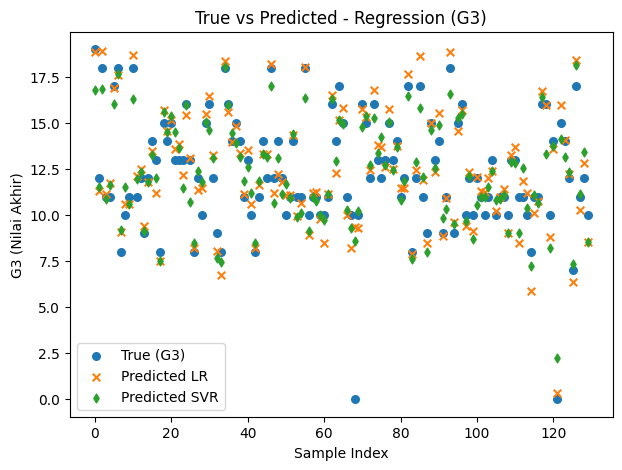

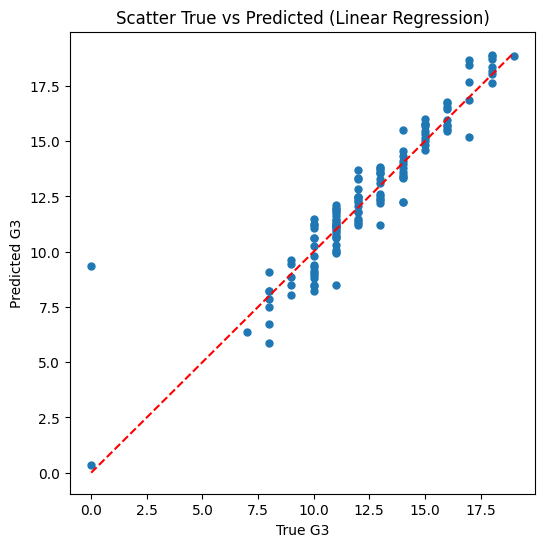

In [15]:
plt.figure(figsize=(7,5))
plt.scatter(range(len(yr_test)), yr_test, label="True (G3)", s=30)
plt.scatter(range(len(y_lr_pred)), y_lr_pred, label="Predicted LR", marker='x', s=30)
plt.scatter(range(len(y_svr_pred)), y_svr_pred, label="Predicted SVR", marker='d', s=20)
plt.title("True vs Predicted - Regression (G3)")
plt.xlabel("Sample Index")
plt.ylabel("G3 (Nilai Akhir)")
plt.legend()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(yr_test, y_lr_pred, s=25)
plt.plot([yr_test.min(), yr_test.max()], [yr_test.min(), yr_test.max()], 'r--')
plt.title("Scatter True vs Predicted (Linear Regression)")
plt.xlabel("True G3")
plt.ylabel("Predicted G3")
plt.show()

Pada bagian klasifikasi, digunakan algoritma Support Vector Classifier (SVC) dengan kernel RBF. Model ini dilatih untuk memprediksi kategori nilai siswa (grade_category). Setelah model selesai dilatih, hasil prediksi dibandingkan dengan nilai sebenarnya menggunakan classification report dan confusion matrix. Classification report menampilkan metrik seperti precision, recall, F1-score, dan accuracy untuk setiap kelas, sedangkan confusion matrix menampilkan jumlah prediksi benar dan salah per kelas. Jika diagonal matriks memiliki nilai tinggi, berarti model bekerja dengan baik.


=== CLASSIFICATION: Support Vector Classifier ===

Classification Report (SVC):
              precision    recall  f1-score   support

         Low       1.00      0.50      0.67         2
      Medium       0.77      0.80      0.79        30
        Good       0.85      0.89      0.87        76
   Excellent       0.89      0.73      0.80        22

    accuracy                           0.84       130
   macro avg       0.88      0.73      0.78       130
weighted avg       0.84      0.84      0.84       130



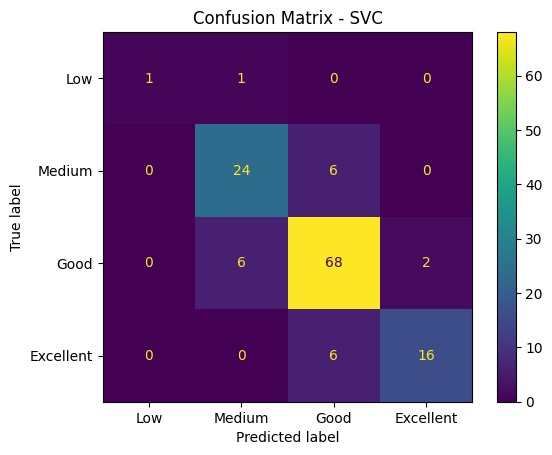

In [16]:
print("\n=== CLASSIFICATION: Support Vector Classifier ===")
svc = SVC(kernel='rbf', C=5, gamma='scale')
svc.fit(Xc_train, yc_train)
y_svc_pred = svc.predict(Xc_test)

print("\nClassification Report (SVC):")
print(classification_report(yc_test, y_svc_pred, target_names=labels))

cm_svc = confusion_matrix(yc_test, y_svc_pred)
disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=labels)
disp_svc.plot()
plt.title("Confusion Matrix - SVC")
plt.show()

Sebagai pembanding tambahan, digunakan algoritma Random Forest, yang merupakan metode ensemble berbasis banyak pohon keputusan (decision tree). Setiap pohon menghasilkan prediksi, dan hasil akhir ditentukan berdasarkan voting mayoritas. Model ini biasanya lebih tahan terhadap overfitting dan dapat menangani data dengan fitur yang banyak. Evaluasi dilakukan menggunakan classification report dan confusion matrix, sama seperti pada SVC. Hasilnya sering kali lebih stabil dan memiliki akurasi tinggi, terutama jika data mengandung hubungan non-linear yang kompleks.


=== CLASSIFICATION BONUS: Random Forest ===

Classification Report (Random Forest):
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00         2
      Medium       0.77      0.80      0.79        30
        Good       0.84      0.91      0.87        76
   Excellent       0.88      0.68      0.77        22

    accuracy                           0.83       130
   macro avg       0.62      0.60      0.61       130
weighted avg       0.82      0.83      0.82       130



C:\Users\TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

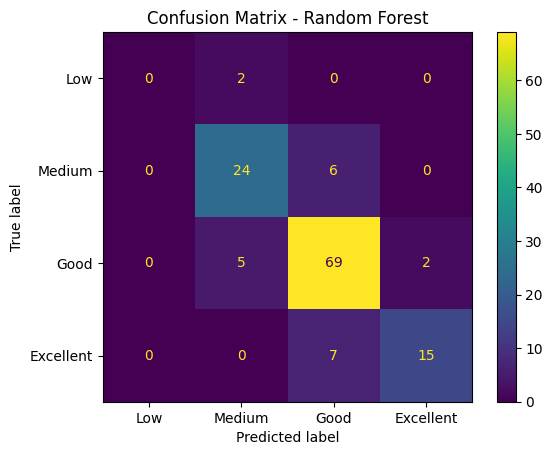

In [17]:
print("\n=== CLASSIFICATION BONUS: Random Forest ===")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(Xc_train, yc_train)
y_rf_pred = rf.predict(Xc_test)

print("\nClassification Report (Random Forest):")
print(classification_report(yc_test, y_rf_pred, target_names=labels))

cm_rf = confusion_matrix(yc_test, y_rf_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=labels)
disp_rf.plot()
plt.title("Confusion Matrix - Random Forest")
plt.show()

Tahap terakhir adalah membuat bar chart yang membandingkan jumlah prediksi dari model SVC terhadap distribusi sebenarnya pada data uji. Grafik ini menunjukkan apakah model memprediksi setiap kategori nilai siswa secara seimbang atau cenderung berat ke salah satu kelas. Jika tinggi batang antara data sebenarnya (True Count) dan hasil prediksi (Predicted Count) hampir sama, maka model berhasil menjaga keseimbangan antar kelas. Visualisasi ini membantu melihat potensi bias model terhadap kelas tertentu.

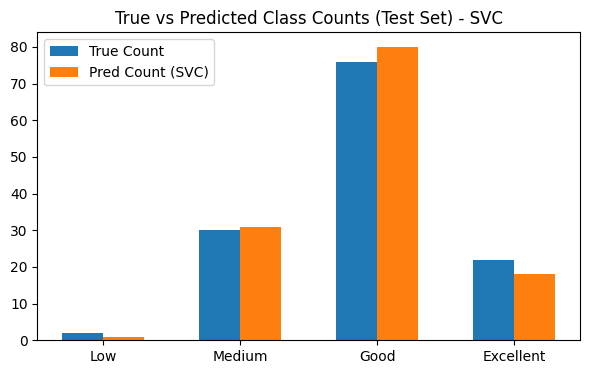

In [18]:
true_counts = pd.Series(yc_test).value_counts().reindex(range(len(labels)), fill_value=0).sort_index()
pred_counts = pd.Series(y_svc_pred).value_counts().reindex(range(len(labels)), fill_value=0).sort_index()

x = np.arange(len(labels))
plt.figure(figsize=(7,4))
plt.bar(x - 0.15, true_counts.values, width=0.3, label='True Count')
plt.bar(x + 0.15, pred_counts.values, width=0.3, label='Pred Count (SVC)')
plt.xticks(x, labels)
plt.title("True vs Predicted Class Counts (Test Set) - SVC")
plt.legend()
plt.show()